In [62]:
#请先运行此代码块获得代码
!DATA_PATH=data/data785/ && NEW_NAME=$(find -name *[0-9].ipynb) && NEW_NAME=${NEW_NAME%.*} && NEW_NAME=${NEW_NAME#./} && unzip -o ${DATA_PATH}数字识别CNNFluid.zip  && cp -rf 数字识别CNN/. . && mv cnn_recognize_digits_complete.cn.ipynb ${NEW_NAME}"_complete.ipynb"

Archive:  data/data785/数字识别CNNFluid.zip
  inflating: 数字识别CNN/cnn_recognize_digits_complete.cn.ipynb  
  inflating: 数字识别CNN/cnn_recognize_digits_homework.cn.ipynb  
  inflating: 数字识别CNN/.ipynb_checkpoints/cnn_recognize_digits_homework.cn-checkpoint.ipynb  
  inflating: 数字识别CNN/.ipynb_checkpoints/cnn_recognize_digits_complete.cn-checkpoint.ipynb  
  inflating: 数字识别CNN/image/cnn.png  
  inflating: 数字识别CNN/image/mlp.png  
  inflating: 数字识别CNN/image/cnn_train_log_en.png  
  inflating: 数字识别CNN/image/mlp_train_log.png  
  inflating: 数字识别CNN/image/mlp_book.png  
  inflating: 数字识别CNN/image/softmax_train_log_en.png  
  inflating: 数字识别CNN/image/cnn_book.png  
  inflating: 数字识别CNN/image/mlp_train_log_en.png  
  inflating: 数字识别CNN/image/cnn_train_log.png  
  inflating: 数字识别CNN/image/softmax_regression.png  
  inflating: 数字识别CNN/image/train_and_test.png  
  inflating: 数字识别CNN/image/softmax_train_log.png  
  inflating: 数字识别CNN/image/cnn_en.png  
  inflating: 数字识别CNN/image/max_pooling_en.png  
  infla

# PaddlePaddle 实现数字识别
欢迎大家来到这次实验，在这次实验中我们将使用 PaddlePaddle 来实现三种不同的分类器，用于识别手写数字。三种分类器所基于的模型分别为 Softmax 回归、多层感知器、卷积神经网络。现在让我们进入实验来看看基于不同模型的分类器的差异吧!

** 你将学会 **

- 实现一个基于Softmax回归的分类器，用于识别手写数字

- 实现一个基于多层感激器的分类器，用于识别手写数字

- 实现一个基于卷积神经网络的分类器，用于识别手写数字

- 卷积神经网络的基本组成和搭建

现在让我们进入实验吧！

## 1 - 引用库

首先，载入几个需要用到的库，它们分别是：

- numpy：一个python的基本库，用于科学计算
- matplotlib：用于生成图，在验证模型准确率和展示成本变化趋势时会使用到
- paddle.fluid：PaddlePaddle深度学习框架
- os：在本例中用于获取文件或目录的路径
- Image：用于处理图像数据

此外，定义一个全局变量，`step`用于后续绘制曲线图。

In [63]:
import numpy as np
import paddle
import paddle.fluid as fluid
import os
try:
    from paddle.fluid.contrib.trainer import *
    from paddle.fluid.contrib.inferencer import *
except ImportError:
    print("In the fluid 1.0,the trainer and inferencer are moving to paddle.fluid.contrib,file=sys.stderr")
    from paddle.fluid.trainer import *
    from paddle.fluid.inferencer import *
from PIL import Image
import matplotlib
# matplotlib.use('Agg')
%matplotlib inline

In the fluid 1.0,the trainer and inferencer are moving to paddle.fluid.contrib,file=sys.stderr


** 问题描述： **

当我们学习编程的时候，编写的第一个程序一般是实现打印"Hello World"。而机器学习（或深度学习）的入门教程，一般都是 [MNIST](http://yann.lecun.com/exdb/mnist/) 数据库上的手写识别问题。原因是手写识别属于典型的图像分类问题，比较简单，同时MNIST数据集也很完备。

** 你的目标： **

构建三种不同的分类器来对手写数字进行识别

** 数据集分析： **

MNIST 数据集作为一个简单的计算机视觉数据集，包含一系列如图1所示的手写数字图片和对应的标签。图片是 28x28 的像素矩阵，标签则对应着0~9的10个数字。每张图片都经过了大小归一化和居中处理。

<p align="center">
<img src="image/mnist_example_image.png" width="400"><br/>
<center>图1. MNIST图片示例</center>
</p>

MNIST数据集是从 [NIST](https://www.nist.gov/srd/nist-special-database-19) 的Special Database 3（SD-3）和Special Database 1（SD-1）构建而来。由于SD-3是由美国人口调查局的员工进行标注，SD-1是由美国高中生进行标注，因此SD-3比SD-1更干净也更容易识别。Yann LeCun等人从SD-1和SD-3中各取一半作为MNIST的训练集（60000条数据）和测试集（10000条数据），其中训练集来自250位不同的标注员，此外还保证了训练集和测试集的标注员是不完全相同的。

Yann LeCun早先在手写字符识别上做了很多研究，并在研究过程中提出了卷积神经网络（Convolutional Neural Network），大幅度地提高了手写字符的识别能力，也因此成为了深度学习领域的奠基人之一。如今的深度学习领域，卷积神经网络占据了至关重要的地位，从最早Yann LeCun提出的简单LeNet，到如今ImageNet大赛上的优胜模型VGGNet、GoogLeNet、ResNet等（请参见[图像分类](https://github.com/PaddlePaddle/book/tree/develop/03.image_classification) 教程），人们在图像分类领域，利用卷积神经网络得到了一系列惊人的结果。

有很多算法在 MNIST 上进行实验。1998年，LeCun 分别用单层线性分类器、多层感知器（Multilayer Perceptron, MLP）和多层卷积神经网络LeNet进行实验，使得测试集上的误差不断下降（从12%下降到0.7%）\[[1](#参考文献)\]。此后，科学家们又基于K近邻（K-Nearest Neighbors）算法\[[2](#参考文献)\]、支持向量机（SVM）\[[3](#参考文献)\]、神经网络\[[4-7](#参考文献)\]和Boosting方法\[[8](#参考文献)\]等做了大量实验，并采用多种预处理方法（如去除歪曲、去噪、模糊等）来提高识别的准确率。

本教程中，我们从简单的模型 Softmax 回归开始，带大家入门手写字符识别，并逐步进行模型优化。

输入值：

- $X$是输入：MNIST图片是$28\times28$ 的二维图像，为了进行计算，我们将其转化为 $784$ 维向量，即 $X=\left ( x_0, x_1, \dots, x_{783} \right )$。转化的具体做法：每张图片是由 $28\times28$ 个像素构成的，将其按固定顺序（如按行或者按列）展开成为一个行向量，并将每个原始像素值归一化为$\left[0,1\right]$ 之间的数值。

- $L$是图片的真实标签：$L=\left ( l_0, l_1, \dots, l_9 \right )$也是10维，但只有一维为1，其他都为0。值为1的维度对应图片表示的真实数字，例如$L=\left ( 1, 0, \dots, 0 \right )$表示图片对应的数字是1。

输出值：

- $Y$是输出：分类器的输出是 10 类数字（0-9），即 $Y=\left ( y_0, y_1, \dots, y_9 \right )$，每一维 $y_i$ 代表图片分类为第 $i$ 类数字的概率。



## 2 - 数据获取

** 文件路径 **

PaddlePaddle在API中提供了自动加载 [MNIST](http://yann.lecun.com/exdb/mnist/) 数据的模块`paddle.dataset.mnist`。

加载后的数据位于`/home/username/.cache/paddle/dataset/mnist`下：


|    文件名称          |       说明              |
|----------------------|-------------------------|
|train-images-idx3-ubyte|  训练数据图片，60,000条数据 |
|train-labels-idx1-ubyte|  训练数据标签，60,000条数据 |
|t10k-images-idx3-ubyte |  测试数据图片，10,000条数据 |
|t10k-labels-idx1-ubyte |  测试数据标签，10,000条数据 |




## 3 - 知识点介绍

### 3.1 常见激活函数介绍  

- sigmoid激活函数： $ f(x) = sigmoid(x) = \frac{1}{1+e^{-x}} $

- tanh激活函数： $ f(x) = tanh(x) = \frac{e^x-e^{-x}}{e^x+e^{-x}} $

  实际上，tanh函数只是规模变化的sigmoid函数，将sigmoid函数值放大2倍之后再向下平移1个单位：tanh(x) = 2sigmoid(2x) - 1 。

- ReLU激活函数： $ f(x) = max(0, x) $

更详细的介绍请参考[维基百科激活函数](https://en.wikipedia.org/wiki/Activation_function)。



### 3.2 - Softmax回归(Softmax Regression)

最简单的Softmax回归模型是先将输入层经过一个全连接层得到的特征，然后直接通过softmax 函数进行多分类\[[9](#参考文献)\]。

输入层的数据$X$传到输出层，在激活操作之前，会乘以相应的权重 $W$ ，并加上偏置变量 $b$ ，具体如下：

$$ y_i = \text{softmax}(\sum_j W_{i,j}x_j + b_i) $$

其中 $ \text{softmax}(x_i) = \frac{e^{x_i}}{\sum_j e^{x_j}} $

对于有 $N$ 个类别的多分类问题，指定 $N$ 个输出节点，$N$ 维结果向量经过softmax将归一化为 $N$ 个[0,1]范围内的实数值，分别表示该样本属于这 $N$ 个类别的概率。此处的 $y_i$ 即对应该图片为数字 $i$ 的预测概率。

在分类问题中，我们一般采用交叉熵代价损失函数（cross entropy），公式如下：

$$  \text{crossentropy}(label, y) = -\sum_i label_ilog(y_i) $$

图2为softmax回归的网络图，图中权重用蓝线表示、偏置用红线表示、+1代表偏置参数的系数为1。

<p align="center">
<img src="image/softmax_regression.png" width=350 heiht="400px"><br/>
<center>图2. softmax回归网络结构图</center><br/>
</p>

### 3.3 - 多层感知器(Multilayer Perceptron, MLP)

Softmax回归模型采用了最简单的两层神经网络，即只有输入层和输出层，因此其拟合能力有限。为了达到更好的识别效果，我们考虑在输入层和输出层中间加上若干个隐藏层\[[10](#参考文献)\]。

1.  经过第一个隐藏层，可以得到 $ H_1 = \phi(W_1X + b_1) $，其中$\phi$代表激活函数，常见的有sigmoid、tanh或ReLU等函数。
2.  经过第二个隐藏层，可以得到 $ H_2 = \phi(W_2H_1 + b_2) $。
3.  最后，再经过输出层，得到的$Y=\text{softmax}(W_3H_2 + b_3)$，即为最后的分类结果向量。


图3为多层感知器的网络结构图，图中权重用蓝线表示、偏置用红线表示、+1代表偏置参数的系数为1。

<p align="center">
<img src="image/mlp.png" width=400><br/>
<center>图3. 多层感知器网络结构图<br/></center>
</p>



### 3.4 - 卷积神经网络(Convolutional Neural Network, CNN)

在多层感知器模型中，将图像展开成一维向量输入到网络中，忽略了图像的位置和结构信息，而卷积神经网络能够更好的利用图像的结构信息。[LeNet-5](http://yann.lecun.com/exdb/lenet/)是一个较简单的卷积神经网络。图4显示了其结构：输入的二维图像，先经过两次卷积层到池化层，再经过全连接层，最后使用softmax分类作为输出层。下面我们主要介绍卷积层和池化层。

<p align="center">
<img src="image/cnn.png" width="75%"><br/>
<center> 图4. LeNet-5卷积神经网络结构<br/></center>
</p>



#### 卷积层

卷积层是卷积神经网络的核心基石。在图像识别里我们提到的卷积是二维卷积，即离散二维滤波器（也称作卷积核）与二维图像做卷积操作，简单的讲是二维滤波器滑动到二维图像上所有位置，并在每个位置上与该像素点及其领域像素点做内积。卷积操作被广泛应用与图像处理领域，不同卷积核可以提取不同的特征，例如边沿、线性、角等特征。在深层卷积神经网络中，通过卷积操作可以提取出图像低级到复杂的特征。

<p align="center">
<img src="image/conv_layer.png" width='75%'><br/>
<center>图5. 卷积层图片<br/></center>
</p>

图5给出一个卷积计算过程的示例图，输入图像大小为$H=5,W=5,D=3$，即$5 \times 5$大小的3通道（RGB，也称作深度）彩色图像。这个示例图中包含两（用$K$表示）组卷积核，即图中滤波器$W_0$和$W_1$。在卷积计算中，通常对不同的输入通道采用不同的卷积核，如图示例中每组卷积核包含（$D=3）$个$3 \times 3$（用$F \times F$表示）大小的卷积核。另外，这个示例中卷积核在图像的水平方向（$W$方向）和垂直方向（$H$方向）的滑动步长为2（用$S$表示）；对输入图像周围各填充1（用$P$表示）个0，即图中输入层原始数据为蓝色部分，灰色部分是进行了大小为1的扩展，用0来进行扩展。经过卷积操作得到输出为$3 \times 3 \times 2$（用$H_{o} \times W_{o} \times K$表示）大小的特征图，即$3 \times 3$大小的2通道特征图，其中$H_o$计算公式为：$H_o = (H - F + 2 \times P)/S + 1$，$W_o$同理。 而输出特征图中的每个像素，是每组滤波器与输入图像每个特征图的内积再求和，再加上偏置$b_o$，偏置通常对于每个输出特征图是共享的。输出特征图$o[:,:,0]$中的最后一个$-2$计算如图5右下角公式所示。

在卷积操作中卷积核是可学习的参数，经过上面示例介绍，每层卷积的参数大小为$D \times F \times F \times K$。在多层感知器模型中，神经元通常是全部连接，参数较多。而卷积层的参数较少，这也是由卷积层的主要特性即局部连接和共享权重所决定。

- 局部连接：每个神经元仅与输入神经元的一块区域连接，这块局部区域称作感受野（receptive field）。在图像卷积操作中，即神经元在空间维度（spatial dimension，即上图示例H和W所在的平面）是局部连接，但在深度上是全部连接。对于二维图像本身而言，也是局部像素关联较强。这种局部连接保证了学习后的过滤器能够对于局部的输入特征有最强的响应。局部连接的思想，也是受启发于生物学里面的视觉系统结构，视觉皮层的神经元就是局部接受信息的。

- 权重共享：计算同一个深度切片的神经元时采用的滤波器是共享的。例如图4中计算$o[:,:,0]$的每个每个神经元的滤波器均相同，都为$W_0$，这样可以很大程度上减少参数。共享权重在一定程度上讲是有意义的，例如图片的底层边缘特征与特征在图中的具体位置无关。但是在一些场景中是无意的，比如输入的图片是人脸，眼睛和头发位于不同的位置，希望在不同的位置学到不同的特征 (参考[斯坦福大学公开课]( http://cs231n.github.io/convolutional-networks/))。请注意权重只是对于同一深度切片的神经元是共享的，在卷积层，通常采用多组卷积核提取不同特征，即对应不同深度切片的特征，不同深度切片的神经元权重是不共享。另外，偏重对同一深度切片的所有神经元都是共享的。

通过介绍卷积计算过程及其特性，可以看出卷积是线性操作，并具有平移不变性（shift-invariant），平移不变性即在图像每个位置执行相同的操作。卷积层的局部连接和权重共享使得需要学习的参数大大减小，这样也有利于训练较大卷积神经网络。



#### 池化层

<p align="center">
<img src="image/max_pooling.png" width="350px"><br/>
<center>图6. 池化层图片<br/></center>
</p>

一般情况下，在连续的卷积层之间会周期性地插入一个池化层（也称汇聚层），其处理输入数据的准则被称为池化函数。池化函数在计算某一位置的输出时，会计算该位置相邻区域的输出的某种总体统计特征，作为网络在该位置的输出。池化层的作用是逐渐降低数据体的空间尺寸，从而减少网络中参数的数量以及耗费的计算资源，同时也能有效控制过拟合。

池化包括最大池化、平均池化、L-2范数池化等。以最大池化(Max Pooling)为例，池化层使用最大化(Max)操作，即用一定区域内输入的最大值作为该区域的输出。最大池化最常用的形式是使用尺寸为$2\times2$、步长为2的滤波器来对每个深度切片进行降采样，每个Max操作是从4个数字中取最大值（也就是在深度切片中某个的区域），这样可以将其中75%的激活信息都过滤掉，而保持数据体通道数不变,具体示例如图6所示。

更详细的关于卷积神经网络的具体知识可以参考[斯坦福大学公开课]( http://cs231n.github.io/convolutional-networks/ )和[图像分类](https://github.com/PaddlePaddle/book/blob/develop/image_classification/README.md)教程。

## 4 - 构建分类器

我们利用PaddlePaddle构建三个不同的分类器：

** Softmax回归：**

只通过一层简单的以Softmax为激活函数的全连接层得到分类结果。具体过程和网络结构如图7所示：784维的输入特征经过节点数目为10的全连接层后，直接通过Softmax函数进行多分类。

<p align="center">
<img src="image/softmax_book.png" width="300px"><br/>
<center>图7. 基于Softmax回归的分类器<br/></center>
</p>

** 练习 **

按照上述描述实现 Softmax 回归分类器对应的 softmax_regression() 函数。


> API 解释
> 全连接 通常写法为 hidden = fluid.layers.fc(input=x, size=10, act='sigmoid')
> 

In [64]:
def softmax_regression():
    """
    定义softmax分类器：
        只通过一层简单的以softmax为激活函数的全连接层，可以得到分类的结果
    Args:
        img -- 输入的原始图像数据
    Return:
        predict_image -- 分类的结果
    """
    img = fluid.layers.data(
        name='img', shape =[1,28,28],dtype = 'float32')
    ### 练习代码开始处 ###(1 -3行代码)
    predict = fluid.layers.fc(input=img,
                              size=10,
                              act='softmax')
    ### 练习代码结束处 ###
    return predict
 

** 多层感知器：**

下面代码实现了一个含有两个隐藏层（即全连接层）的多层感知器。其中两个隐藏层的激活函数均采用ReLU，输出层的激活函数用 Softmax。Softmax 回归模型采用了最简单的两层神经网络，即只有输入层和输出层，因此其拟合能力有限。为了达到更好的识别效果，我们考虑在输入层和输出层中间加上若干个隐藏层,从而得到了多层感知器模型。其对应的网络结构如图7所示：784维的输入特征，先后经过两个节点数为128和64的全连接层，最后通过 Softmax 函数进行多分类。

<p align="center">
<img src="image/mlp_book.png" width="350px"><br/>
<center>图7. 基于多层感知器模型的分类器<br/></center>
</p>

** 练习 **
按照上述描述定义多层感知器模型对应的函数 multilayer_perceptron()。

> API 解释
> 全连接 通常写法为 hidden = fluid.layers.fc(input=x, size=10, act='sigmoid')
> 

In [65]:
def multilayer_perceptron():
    """
    定义多层感知机分类器：
        含有两个隐藏层（即全连接层）的多层感知器
        其中两个隐藏层的激活函数均采用 ReLU，输出层的激活函数用 Softmax
    Args:
        img -- 输入的原始图像数据
    Return:
        predict_image -- 分类的结果
    """
    
    img = fluid.layers.data(
        name='img', shape =[1,28,28],dtype = 'float32')
   # 第一个全连接层，本层神经元有128个 激活函数为 ReLU 
    ### 练习代码开始处 ### (1行代码)
    hidden1 = fluid.layers.fc(input=img, size=128, act='relu')
    ### 练习代码结束处 ###
    
    # 第二个全连接层，本层神经元有64个 激活函数为 ReLU 
    ### 练习代码开始处 ###（1行代码）
    hidden2 = fluid.layers.fc(input=hidden1,
                              size=64,
                              act='relu')
    ### 练习代码结束处 ###
    
    # 以 softmax 为激活函数的全连接输出层，输出层的大小必须为 10,对应 0-9 这 10 个数字
    ### 练习代码开始处 ###（1行代码）
    predict = fluid.layers.fc(input=hidden2,
                              size=10,
                              act='softmax')
    ### 练习代码结束处 ###
    return predict


** 卷积神经网络: **

下方代码实现了一个卷积神经网络分类器，其网络结构如图8所示：输入的二维图像，经过两次卷积层后接池化层的结构，在通过输出节点数目为10的以Softmax函数作为激活函数的全连接层后得到多分类输出。

<p align="center">
<img src="image/cnn_book.png" width="700px"><br/>
<center>图8. 卷积神经网络分类器<br/></center>
</p>

** 练习 **

根据上述描述和图示，实现卷积神经网络模型对应的函数 convolutional_neural_network()。


> **API 解释**  
> **卷积** 通常写法为 hidden = fluid.nets.simple_img_conv_pool(input, num_filters, filter_size, pool_size, pool_stride, pool_padding=0)
> 其中: 
>    input - 输入   
>    num_filters - filters 的数量  
    filter_size - filter 的大小  
    pool_size - 池化的大小  
    pool_stride - 池化的步长  
    pool_padding - 池化的 padding  
> API 参考文档：http://www.paddlepaddle.org/docs/0.14.0/api/fluid/en/nets.html#simple-img-conv-pool
> 
> **Batchnorm** 通常写法 hidden = fluid.layers.batch_norm(input)
> 其中: 
>    input - 输入  
> API 参考文档：http://www.paddlepaddle.org/docs/0.14.0/api/fluid/en/layers.html#batch-norm 
> 知识参考文档：https://blog.csdn.net/qq_25737169/article/details/79048516

In [66]:

def convolutional_neural_network():
    """
    定义卷积神经网络分类器：
        输入的二维图像，经过两个卷积-池化层，使用以softmax为激活函数的全连接层作为输出层
    Args:
        img -- 输入的原始图像数据
    Return:
        predict -- 分类的结果
    """
    img = fluid.layers.data(
        name='img', shape =[1,28,28],dtype = 'float32')
 # 第一个卷积-池化层
    # 基本设置参考： filter 的数量 20
    ### 练习代码开始处 ### （1-8行代码）
    conv_pool_1 = fluid.nets.simple_img_conv_pool(
        input=img,
        filter_size=5,
        num_filters=20,
        pool_size=2,
        pool_stride=2,
        act='relu')
    conv_pool_1 = fluid.layers.batch_norm(conv_pool_1)
    ### 练习代码结束处 ###
    
    # 第二个卷积-池化层
    # 基本设置参考： filter 的数量 50
    ### 练习代码开始处 ### （1-8行代码）
    conv_pool_2 = fluid.nets.simple_img_conv_pool(
        input=conv_pool_1,
        filter_size=5,
        num_filters=50,
        pool_size=2,
        pool_stride=2,
        act='relu')
    ### 练习代码结束处 ###
    
    # 以softmax为激活函数的全连接输出层，输出层的大小必须为10,对应0-9这10个数字
    ### 练习代码开始处 ### （1-3行代码）
    predict = fluid.layers.fc(input=conv_pool_2,
                              size=10,
                              act='softmax')

    ### 练习代码结束处 ###
    return predict



## 5 - 训练过程

在构建完成分类器后，接下来进入模型的训练过程，一般步骤如下：

- 设置训练场所
- 配置网络结构和优化方法
    - 配置网络结构
    - 定义损失函数 cost
    - 定义优化器 optimizer
- 训练准备
    - 定义输入数据与网络的映射关系
    - 定义文件路径
    - 事件处理函数
    - 定义执行器
        - 初始化网络参数
- 模型训练
    - 定义 reader
    - 定义 trainer 
    - 开始训练


### ** （1）设置训练场所 **

首先进行设置训练使用的设备。在复杂量较低的时候使用 CPU 就可以完成任务，但是对于大规模计算就需要使用 GPU 训练。目前 GPU 训练都是基于 CUDA 工具之上的。
- use_cuda=False 表示不使用 GPU 进行训练

In [67]:
# 设置训练场所
use_cuda = False
# use_cuda = True
place = fluid.CUDAPlace(1) if use_cuda else fluid.CPUPlace()

### ** （2）配置网络结构和优化方法 **
这一阶段，我们关注的是网络拓扑结构的配置和优化方法的配置

** 网络结构 **  
接下来需要配置分类网络的结构，首先通过 layers.data 配置数据输入层，然后配置分类器（代码中提供了三个不同的分类器，每次使用选择其中一个，注释掉其余两个即可）。例如下方代码中选用的是卷积神经网络分类器。  
然后设置损失函数，对于分类问题常常选择交叉熵损失函数。  


In [68]:
def train_func():
    """
    配置网络结构
    Args:
    Return:
        label -- 标签数据
        predict -- 输出层
        cost -- 损失函数
        optimizer -- 优化器
    """
    """
    标签层:
        name=’label’：名称为label,对应输入图片的类别标签
    """
    label = fluid.layers.data(name='label', shape = [1],dtype = 'int64')


    """ 
    选择分类器：
        在此之前已经定义了3种不同的分类器，在下面的代码中,
        我们可以通过保留某种方法的调用语句、注释掉其余两种，以选择特定的分类器
    """
#     predict = softmax_regression()
    predict = multilayer_perceptron()
#     predict = convolutional_neural_network()

    # 损失函数，cross_entropy 函数内部使用交叉熵损失函数
    cost = fluid.layers.cross_entropy(input=predict, label=label)
    avg_cost = fluid.layers.mean(cost)
    return avg_cost



** optimizer **  

1. 创建优化器 
这里可以尝试采用 Momentum 或 Adam 优化器。 

2. 使用优化器  
- 训练过程在更新权重时采用动量优化器 `Momentum` ，Momentum是为了让目标函数沿梯度方向快速收敛的一种加速学习方法，其中参数 0.9 代表动量优化每次保持前一次速度的 0.9 倍。
- 训练速度（learning_rate）： 迭代的速度，与网络的训练收敛速度有关系。


** 练习： **
1. 创建Adam优化器并且设置参数值：learning_rate=0.2, beta1=0.9, beta2=0.999 和 epsilon=1e-08

> **API解释**  
> **动量** 通常写法：optimizer = fluid.optimizer.Momentum(learning_rate= 0.1 , momentum= 0.9)  
>API 参考地址：http://www.paddlepaddle.org/docs/0.14.0/api/fluid/en/optimizer.html#permalink-9-momentumoptimizer

** \*\*特别的\*\* **  
由于本例使用 trainer 的写法，所以需要将优化器包装到函数中方便后面使用。  


In [69]:
def optimizer_func():
    # 创建优化器optimizer，下面列举了2种常用的优化器，不同类型优化器选一即可
    # 创建Momentum优化器，并设置学习率(learning_rate)、动量(momentum)
    ### 练习代码开始处 ### （1-3行代码）
    optimizer = fluid.optimizer.Momentum(
    learning_rate=0.001,
    momentum=0.9)
    ### 练习代码结束处 ###
    
    return optimizer

### ** （3）训练准备 **
这个阶段我们关注的是小的相关内容的配置。  
** 定义映射 **  
输入网络的数据要与网络本身应该接受的数据相匹配。在 fluid 中使用 feed_order 的概念来保证输入的数据与网络接受的数据的顺序是一致的。本示例中使用 feed_order = ['x', 'label'] 来告知网络，输入的数据是分为两部分，第一部分是 x 值，第二部分是 label 值。

In [70]:
feed_order = ['img', 'label'] 

** 定义文件路径 **  

在 fluid 中，默认模型的相关数据是需要保存在硬盘上的。也就是说在训练阶段会将训练好的模型保存在硬盘上，在将预测阶段可以直接 load 磁盘上的模型数据，进而做出预测。

In [71]:
params_dirname = "./DNN_model"

** 定义事件处理函数 **  
在 fluid 中，如果是用 trainer 的方式来训练的话，那么，在训练的时候允许开发者自己定义事件回调函数。目前接受的事件有 BeginEpochEvent、EndEpochEvent、BeginStepEvent、EndStepEvent。
 用于输出训练过程中 cost 的变化。

In [72]:

# Plot data
from paddle.v2.plot import Ploter
train_title = "Train cost"
test_title = "Test cost"
plot_cost = Ploter(train_title, test_title)

step = 0
# 事件处理
def event_handler_plot(event):
    global step
    if isinstance(event, fluid.EndStepEvent):
        if event.step % 2 == 0: # 若干个batch,记录cost
            if event.metrics[0] < 10:
                plot_cost.append(train_title, step, event.metrics[0])
                plot_cost.plot()
        if event.step % 20 == 0: # 若干个batch,记录cost
            test_metrics = trainer.test(
            reader=test_reader, feed_order=feed_order)
            if test_metrics[0] < 10:
                plot_cost.append(test_title, step, test_metrics[0])
                plot_cost.plot()

#             if test_metrics[0] < 1.0:
#                 # 如果准确率达到阈值，则停止训练
#                 print('loss is less than 10.0, stop')
#                 trainer.stop()

        # 将参数存储，用于预测使用
        if params_dirname is not None:
            trainer.save_params(params_dirname)
    step += 1

** 定义执行器 **   
为了能够运行开发者定义的网络拓扑结构和优化器，需要定义执行器。由执行器来真正的执行参数的初始化和网络的训练过程。

In [73]:
# 创建执行器，palce在程序初始化时设定
exe = fluid.Executor(place)
# 初始化执行器
exe.run( fluid.default_startup_program() )

[]

### （4）** 模型训练 **

** 定义reader **   
网络接受的数据实际上是一个又一个的 mini-batch 。 paddle 框架为开发者准备好了 paddle.batch 函数来提供一个又一个 mini-batch。在实际输入数据的时候，我们希望的是数据顺序不要影响网络是训练，paddle 框架也准备了 paddle.reader.shuffle 函数来打乱输入的顺序。 

** 练习： **
设置 BATCH_SIZE 为 10 
> BATCH_SIZE 的大小决定了 每个 mini-batch 中灌入的数据的数量

In [74]:
# 设置 BATCH_SIZE 的大小
### 练习代码开始处 ### (1行代码) 
BATCH_SIZE = 128
### 练习代码结束处 ###

# 设置训练reader
train_reader = paddle.batch(
    paddle.reader.shuffle(
        paddle.dataset.mnist.train(), 
        buf_size=500),
    batch_size=BATCH_SIZE)

#设置测试 reader
test_reader = paddle.batch(
    paddle.reader.shuffle(
        paddle.dataset.mnist.test(), 
        buf_size=500),
    batch_size=BATCH_SIZE)

** 定义trainer **   
trainer 负责收集训练需要的相关信息。定义 trainer 时需要提供 3个重要信息：
1. 网络拓扑结构，通过参数 train_func 设定
2. 真实训练的设备，通过参数 place 设定
3. 优化方法，通过参数 optimizer_func 设定

In [75]:
#创建训练器
trainer = Trainer(
    train_func= train_func,
    place= place,
    optimizer_func= optimizer_func)


** 开始训练 **  
在做好了所有的准备工作之后，就开始开始训练了。由于本例使用的是 trainer 的方法，所以可以直接调用 trainer 的 train 方法来执行训练。train 方法主要需要设置3个参数： reader、num_epochs 和 feeder_order。
其中，  
>reader 表示能够持续提供 mini-batch 的数据源  
>num_epochs 表示所有的数据将要训练多少轮次（就是一个数字）  
>feeder_order 表示数据的顺序。

我们注意到，reader 和 feeder_order 在前面的准备过程中已经准备好了。 除了这三个参数外，train 还接受一个 event_handler 参数。这个参数允许开发者自己定义回调函数，用以在训练过程中打印训练相关的信息，甚至在合适的时候停止训练。  
函数的形式如下：
```
trainer.train(
    reader= ,
    num_epochs= ,
    event_handler= ,
    feed_order= )
```
** 练习： **
1. 编写 train 函数
2. 将 num_epochs 设置为 3

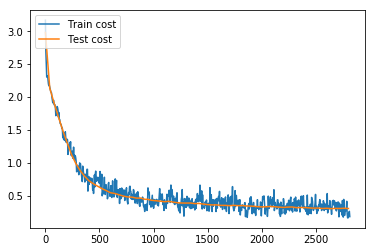

<Figure size 432x288 with 0 Axes>

In [76]:

### 练习代码开始处 ### (4行代码左右)
trainer.train(
    reader=train_reader,
    num_epochs=3,
    event_handler=event_handler_plot,
    feed_order=feed_order)
### 练习代码开始处 ###

 
## 6 - 预测过程

**首先**，定义一个用来处理输入的图片的函数 load_image(file)。 它会将输入的图片处理成满足分类器输入要求的格式。

In [77]:
def load_image(file):
    """
    定义读取输入图片的函数：
        读取指定路径下的图片，将其处理成分类网络输入数据对应形式的数据，如数据维度等
    Args:
        file -- 输入图片的文件路径
    Return:
        im -- 分类网络输入数据对应形式的数据
    """
    im = Image.open(file).convert('L')
    im = im.resize((28, 28), Image.ANTIALIAS)
    im = np.array(im).reshape(1, 1, 28, 28).astype(np.float32)
    im = im / 255.0 * 2.0 - 1.0
    return im

**然后**，我们预测输入图片的标签。其会调用之前定义的 load_image(file) 函数处理要预测的图片。接着调用 fluid.Inferencer.infer 接口来预测图片类型。

In [82]:

# 读取并预处理要预测的图片
cur_dir = os.getcwd()
img = load_image(cur_dir + '/image/infer_3.png')

# 设置训练场所
use_cuda = False
# use_cuda = True
place = fluid.CUDAPlace(1) if use_cuda else fluid.CPUPlace()

inferencer = Inferencer(
    infer_func=softmax_regression, # uncomment for softmax regression
#     infer_func=multilayer_perceptron, # uncomment for MLP
#     infer_func=convolutional_neural_network,  # uncomment for LeNet5
    param_path=params_dirname,
    place=place )

results = inferencer.infer({'img': img})
lab = np.argsort(results)  # probs and lab are the results of one batch data
print("Label of image/infer_3.png is: %d" % lab[0][0][-1])

Label of image/infer_3.png is: 73



## 7 - 总结

通过这个练习我们应该记住：

1. 基于Softmax回归、多层感知器、卷积神经网络构建分类器的操作

2. 如何利用PaddlePaddle的API接口对图片进行特征提取和分类


本教程的softmax回归、多层感知器和卷积神经网络是最基础的深度学习模型，后续章节中复杂的神经网络都是从它们衍生出来的，因此这几个模型对之后的学习大有裨益。同时，我们也观察到从最简单的softmax回归变换到稍复杂的卷积神经网络的时候，MNIST数据集上的识别准确率有了大幅度的提升，原因是卷积层具有局部连接和共享权重的特性。在之后学习新模型的时候，希望大家也要深入到新模型相比原模型带来效果提升的关键之处。作为扩展，大家可以用自己的数据，定义自己的网络模型，并完成自己的训练和预测任务。


## 参考文献

1. LeCun, Yann, Léon Bottou, Yoshua Bengio, and Patrick Haffner. ["Gradient-based learning applied to document recognition."](http://ieeexplore.ieee.org/abstract/document/726791/) Proceedings of the IEEE 86, no. 11 (1998): 2278-2324.
2. Wejéus, Samuel. ["A Neural Network Approach to Arbitrary SymbolRecognition on Modern Smartphones."](http://www.diva-portal.org/smash/record.jsf?pid=diva2%3A753279&dswid=-434) (2014).
3. Decoste, Dennis, and Bernhard Schölkopf. ["Training invariant support vector machines."](http://link.springer.com/article/10.1023/A:1012454411458) Machine learning 46, no. 1-3 (2002): 161-190.
4. Simard, Patrice Y., David Steinkraus, and John C. Platt. ["Best Practices for Convolutional Neural Networks Applied to Visual Document Analysis."](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.160.8494&rep=rep1&type=pdf) In ICDAR, vol. 3, pp. 958-962. 2003.
5. Salakhutdinov, Ruslan, and Geoffrey E. Hinton. ["Learning a Nonlinear Embedding by Preserving Class Neighbourhood Structure."](http://www.jmlr.org/proceedings/papers/v2/salakhutdinov07a/salakhutdinov07a.pdf) In AISTATS, vol. 11. 2007.
6. Cireşan, Dan Claudiu, Ueli Meier, Luca Maria Gambardella, and Jürgen Schmidhuber. ["Deep, big, simple neural nets for handwritten digit recognition."](http://www.mitpressjournals.org/doi/abs/10.1162/NECO_a_00052) Neural computation 22, no. 12 (2010): 3207-3220.
7. Deng, Li, Michael L. Seltzer, Dong Yu, Alex Acero, Abdel-rahman Mohamed, and Geoffrey E. Hinton. ["Binary coding of speech spectrograms using a deep auto-encoder."](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.185.1908&rep=rep1&type=pdf) In Interspeech, pp. 1692-1695. 2010.
8. Kégl, Balázs, and Róbert Busa-Fekete. ["Boosting products of base classifiers."](http://dl.acm.org/citation.cfm?id=1553439) In Proceedings of the 26th Annual International Conference on Machine Learning, pp. 497-504. ACM, 2009.
9. Rosenblatt, Frank. ["The perceptron: A probabilistic model for information storage and organization in the brain."](http://psycnet.apa.org/journals/rev/65/6/386/) Psychological review 65, no. 6 (1958): 386.
10. Bishop, Christopher M. ["Pattern recognition."](http://users.isr.ist.utl.pt/~wurmd/Livros/school/Bishop%20-%20Pattern%20Recognition%20And%20Machine%20Learning%20-%20Springer%20%202006.pdf) Machine Learning 128 (2006): 1-58.
11. http://ufldl.stanford.edu/tutorial/supervised/OptimizationStochasticGradientDescent/
